In [1]:
#importing packages
import pandas as pd
import numpy as np 
import networkx as nx
import pickle
from collections import Counter 
from tqdm import tqdm
from scipy.sparse import csr_matrix
import networkx as nx
from sklearn.manifold import TSNE
from scipy.sparse import identity, diags
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt

# Reading Data <br>

Reading the "edges.csv" file into a pandas DataFrame, and then dropping duplicate rows.

<b>Variables</b>:<br>
\------------<br>
<b>edges:pd.DataFrame</b><br>
Contains two columns,["Source","Target"], representing directional edge from the source node to the target node.

<br>
<b>Params</b>:<br>
------------<br>
edges

In [3]:
#importing data 
edges = pd.read_csv('edges.csv')
edges = edges.drop_duplicates()


# Creating Directional Graph - 1 <br>
Creating a Networkx directional graph. Then iterating <br>
through the DataFrame containing the edges and inserting the edges.<br>
Networkx automatically adds nodes.

<b>Variables</b>: <br>
\----------<br>
<b>G: Networkx directional Graph obect</b><br>
Networkx directional graph we add nodes & edges to<br>
edges (pd.DataFrame) : Dataframe containing the graph edges



In [5]:
#Creating Graph Object 
G = nx.DiGraph()

#Creating Network 
for i,r in edges.iterrows():
    source_node = r['Source']
    target_node = r['Target']
    G.add_edge(source_node,target_node)

""" 
Note: Instead of running the code above to create the graph, you can read a pickled graph object for faster execution.
"""
# import pickle 
# G = pickle.load(open('graph.pickle','rb'))


# Calculate Page Rank for all Nodes - 2

Calculate the pagerank of the graph (G), with a damping factor(alpha = 0.85), which returns a dictionary. Then the dictionary is converted into a dataframe, which is then stored into a csv file.

<b>Variables</b>:<br>
\------------<br>
<b>alpha:float</b><br>
The damping factor. It is the probability of a random jump in the network. Page rank either follows a directed edge to a neighboring node or teleports to a random node in the network with probability (1-alpha). A higher value of alpha means its more likely to follow the edges and less likely to teleport. A higher alpha emphasizes the importance of incoming nodes. Its standard practice to use 0.85

<b>pageRank_values: dictionary(int):(float)</b><br>
A dictionary containing the pagerank value of each node.

<b>pagerank_df: pd.DataFrame</b><br>
Dataframe containing each Node and its corresponding pagerank value

In [34]:
alpha = .85 
pageRank_values = nx.pagerank(G,alpha =alpha)
pagerank_df = pd.DataFrame.from_dict(pageRank_values,orient ="index").reset_index()
pagerank_df.columns = ['Node','PageRank']
pagerank_df.to_csv('page_rank.csv',index = False)

# Community Detection - 3
Detecting network communities, and their member nodes using the Louvain algorithm. Next each node is assign their respective community in a dictionary. This dicitonary is then converted into a pd.DataFrame and csv. Lastly, each node in the Graph (G) gets labeled with their community integer.

<b>Variables</b>:<br>
\------------<br>
<b>comms:list[set]</b><br> Returns a list of sets, where each set is a community. Each set contains the member nodes.

<b>comms_list: dict[int:int]</b><br>
A dictionary containing the node(key), and community(value).

<b>comms_df :pd.DataFrame </b><br>
A data frame containing each node and their respective community


In [19]:
#Detecting Communities 
comms = nx.community.louvain_communities(G)

#Creating a dict that lists every node, and their community
comm_list = dict()
for i,comm in enumerate(comms):
    for node in comm:
        comm_list[node] = [i]

#Creating DataFrame
comms_df = pd.DataFrame(comm_list).T
comms_df = comms_df.reset_index()
comms_df.columns = ['Node','Community']
comms_df.to_csv("communities.csv",index = False)

In [ ]:
def set_node_community(G, communities):
    '''Add community to node attributes
    Parameters
    ----------
    G:Networkx Graph
                    The graph to which nodes we assign a community number
    
    communities: list[set(Nodes)]
                    A list of sets, where each set contains the integer representation of the nodes
    '''
    for c, v_c in enumerate(communities):
        for v in v_c:
            # Add 1 to save 0 for external edges
            G.nodes[v]['community'] = c + 1

set_node_community(G, comms)

# Set Color based off community
A function called get_color that generates a color based on an integer value.
This function is used to assign colors to each node, based on their community
integer value. This value is then stored in a list, pd.DataFrame, and csv file

<b>Variables</b><br>
\----------<br>
<b>node_color: List[Tuple(int,int,int)]</b><br>
                A list of tuples, where each tuple is an integer corresponding to red, blue, green
                
<b>node_color_dict: Dict[Node: (R,G,B)]</b><br>
                A dictionary where the key is the node, and the value is their respective community color R,G,B


In [18]:
def get_color(i,number_of_colors = 100,  r_off=1, g_off=1, b_off=1):
    '''Assign a color to a node based on their community number "i".

    Parameters
    ----------
    i: int
                I is the respective community number
    number_of_colors: int
                The number of possible colors that will be used.
    r_off:(int)
                Red color offset
    g_off: int
                Green color offset
    b_off: int
                Blue color offset    
    Returns
    -------
    (r, g, b):(int,int,int)
                red, green, and blue integer color
    '''
    r0, g0, b0 = 0, 0, 0
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % number_of_colors) / (number_of_colors - 1)
    g = low + span * (((i + g_off) * 5) % number_of_colors) / (number_of_colors - 1)
    b = low + span * (((i + b_off) * 7) % number_of_colors) / (number_of_colors - 1)
    return (r, g, b)

#node color list to use when plotting 
node_color = [get_color(G.nodes[v]['community']) for v in G.nodes]

#Storing Node Colors dictionary in pd.DataFrame 
node_color_dict = {v:get_color(G.nodes[v]['community']) for v in G.nodes}
node_color_df = pd.DataFrame(node_color_dict).T
node_color_df = node_color_df.reset_index()
node_color_df.columns = ['Node','R','G','B']
#Exporting dataframe to csv
node_color_df.to_csv('node_colors.csv',index = False)

# Degree Distribution - 6
Getting each nodes degree and storing it in a dictionary. The dictionary is converted to a pd.DataFrame and csv. Then the nodes and their respective degree count is plotted, and compared against the power law distribution.

Please note that we use G.Degree(). However, since this is a directed graph this function sums the in and out degree. This could be changed to G.in_degree() to get a clearer picture of who people listen to more. 

<b>Variables</b><br>l
\----------<br>
<b>node_degree: Dict</b><br>
                Dictionary containing each nodes degree.

<b>node_degree_df: pd.DataFrame</b><br>
                Dataframe containing each nodes degree.

In [26]:
#Extracting node, and degree from Graph into DataFrame
node_degrees = {n:d for n,d in G.degree()}
node_degrees_df = pd.DataFrame.from_dict(node_degrees,orient='index').reset_index()
node_degrees_df.columns = ['Node','Degrees']
node_degrees_df.to_csv('node_degrees.csv',index = False)

Text(0.5, 1.0, 'Degree plot of network')

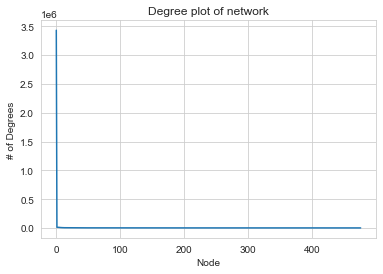

In [83]:
#visualizing 
degree_counts = pd.DataFrame.from_dict(dict(Counter(node_degrees_df['Degrees'])),orient='index').reset_index()
degree_counts.columns = ['degree','count']
degree_counts.sort_values(by =['degree'],ascending=False,inplace=True)
degree_counts['degree'].drop_duplicates().reset_index()['degree'].plot()
plt.xlabel('Node')
plt.ylabel('# of Degrees')
plt.title("Degree plot of network")

<AxesSubplot:>

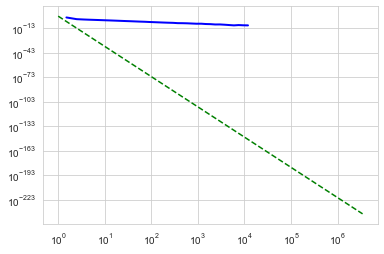

In [90]:
#visualizing the nodes distribution against the power law distribution
import powerlaw
pfit = powerlaw.Fit(node_degrees_df['Degrees'].tolist(),xmin = 1)
fig2 = pfit.plot_pdf(color='b', linewidth=2)
pfit.power_law.plot_pdf(color='g', linestyle='--', ax=fig2)
"""
Green: Ideal Power Law 
Blue: Twitter Data fit 
"""

# Detecting Influencers/Hubs for each community 
Hubs/influencers are detected by first calculating each nodes in degree centrality, which is stored in the in_degre_df. Then the comms_df, which is the dataframe containing each node and their respective community is merged to in_degree_df. Next, the pagerank_df is merged in with the previous two data frames. Lastly, we get the top 1% of nodes, based on their in degree centrality or pagerank. This is to capture both community internal influencers, and nodes that connect two communities together. 



<b>Variables</b><br>
\----------<br>
<b>In_degree_dic: dict</b><br>
                Dictionary Containing each nodes in degree centrality

<b>In_degree_df: pd.DataFrame</b><br>
                Dataframe containing each nodes in degree centrality

<b>influencers_measures: pd.DataFrame</b><br>
                Dataframe containing each nodes in degree centrality and pagrank centrality measures
    

In [42]:
#Calculating indegree & merging with the community labeled dataframe
in_degree_dict = nx.in_degree_centrality(G)
in_degree_df = pd.DataFrame.from_dict(in_degree_dict, orient='index')
in_degree_df = in_degree_df.reset_index()
in_degree_df.columns = ['Node','in_degree']
# comms_df = pd.read_csv('Stats/communities.csv') if the communities cell hasnt been run, use the csv file
in_degree_df = in_degree_df.merge(comms_df, how = 'left', on = 'Node')
influencer_measures = in_degree_df.merge(pagerank_df,how = 'left', on = 'Node')

In [43]:
#Getting top 1% of each community based on the in degree
communities = influencer_measures['Community'].unique()
influencer_measures['degree_influencer']  = 0
influencer_measures['pagerank_influencer']  = 0
top_pct = .01
for community in communities: 
    #degree based influencers
    temp_df = influencer_measures[influencer_measures['Community']==community] 
    temp_df = temp_df.sort_values(by = ['in_degree'], ascending = False)
    top_nodes = int(len(temp_df)*top_pct)
    temp_df_degree = temp_df.iloc[:top_nodes]
    influencer_list = temp_df_degree['Node'].tolist()
    influencer_measures.loc[influencer_measures['Node'].isin(influencer_list),'degree_influencer'] = 1

    #pagerank based influencers
    temp_df = temp_df.sort_values(by = ['PageRank'], ascending = False)
    temp_df_pagerank = temp_df.iloc[:top_nodes]
    influencer_list = temp_df_pagerank['Node'].tolist()
    influencer_measures.loc[influencer_measures['Node'].isin(influencer_list),'pagerank_influencer'] = 1
    influencer_measures['influencer'] = influencer_measures[['degree_influencer','pagerank_influencer']].sum(axis = 1)

#filtering out for only those in the top 1% in terms of pagerank or in degree centrality
influencer_measures = influencer_measures[(influencer_measures['influencer']>0)]
influencer_measures.to_csv('Stats/influencer_nodes.csv',index = False)


# All Cliques 
Find all network cliques based on the Bron and Kerbosch algorithm. These cliques are then stored in a pd.DataFrame and csv file.

<b>Variables</b><br>
\----------<br>
<b>G_und: Netwokrx Graph</b><br>
                Undirected netwokx graph. This was used, since the find_clique algorithm only work on undirected graphs

<b>c: pd.DataFrame</b><br>
                Dataframe containing each clique

In [4]:
G_und = nx.to_undirected(G)
c = list(nx.find_cliques(G_und))
cliques = pd.DataFrame(c).fillna("")
cliques.to_csv('cliques.csv',index = False)

# Converting graph to a scipy sparse matrix
The graphs is converted into an undirected graph, which is then converted into scipy sparse matrix. This was done to conserve memory, as a standard np.array required too much ram.

<b>G_und: Netwokrx Graph</b><br>
                Undirected netwokx graph.

<b>A: Scipy Sparse Matrix</b><br>
                A scipy sparse matrix to conserve memory

In [4]:
G_und = nx.to_undirected(G)
A = nx.to_scipy_sparse_matrix(G, dtype='uint8')

/tmp/ipykernel_157922/3289671299.py:3: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `to_scipy_sparse_array` instead.
  A = nx.to_scipy_sparse_matrix(G, dtype='uint8')


# Computing X,Y coordinates 

Decompose the graph into a 2d dimensional data using the t-SNE or T-distributed Stochastic Neighbourhood Embedding. Firt the Laplacian, eigenvectors and egienvalues are computed. Next the data is fit using the t-sne model. Lastly the coordinates are stored in a dicitonary, pd.DataFrame, and csv file

<b>Variables</b><br>
\----------<br>
<b>D: scipy.sparse.dia_matrix</b><br>
                is a diagonal matrix with the degree of each node on its diagonal.

<b>L: scipy.sparse.csr_matrix</b><br>
                is the Laplacian matrix obtained by subtracting the adjacency matrix `A` from `D`.Compute the eigenvectors and eigenvalues of `L` using sparse matrix operations to obtain `k` eigenvectors.

<b>K: int</b><br>
                The number of eigenvectors and eigenvalues of the Laplacian matrix `L` to compute.

<b>vals: numpy.ndarray</b><br>
                A 1D array containing the `k` smallest eigenvalues of the Laplacian matrix `L`.

<b>vecs: numpy.ndarray</b><br>
                A 2D array where each column is an eigenvector corresponding to the `k` smallest eigenvalues of `L`.

<b>X: numpy.ndarray</b><br>
                A 2D array containing the `k` eigenvectors corresponding to the `k` smallest eigenvalues of `L`.


<b>tsne: sklearn.manifold.TSNE </b><br>
                A t-SNE (t-Distributed Stochastic Neighbor Embedding) object, used for dimensionality reduction.

<b>X_tsne: numpy.ndarray</b><br>
                A 2D array containing the transformed data obtained by applying the t-SNE algorithm to the matrix `X`.

<b>pos: dict </b><br>
                A dictionary where the keys are nodes of the graph `G` and the values are 2D numpy arrays containing the x,y coordinates of all nodes in the graph.



In [5]:


# Compute the graph Laplacian
D = diags(np.asarray(A.sum(axis=1)).squeeze(), 0)
L = D - A
print('eigens')
# Compute the eigenvectors and eigenvalues of the Laplacian using sparse matrix operations
k = 10
vals, vecs = eigsh(L, k=k, which='SM')
X = vecs[:, 1:k]
print('tsne')
# Initialize a t-SNE object with specified parameters
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, method='barnes_hut')
print('transform')
# Fit the t-SNE model to the data
X_tsne = tsne.fit_transform(X)
print('coordinates')
# Get the x,y coordinates for all nodes
pos = {}
for i, node in enumerate(G.nodes()):
    pos[node] = X_tsne[i]

diagnels
eigens
tsne
transform
coordinates


In [13]:
pos_df = pd.DataFrame.from_dict(pos)
pos_df = pos_df.T
pos_df  = pos_df.reset_index()
pos_df.columns = ['Node','X','Y']
pos_df.to_csv('coordinates.csv',index = False)

In [19]:

plt.scatter(np.array(list(pos.values()))[:,0], np.array(list(pos.values()))[:,1],c = node_color )
plt.show()


In [12]:
#Combining key stats 
comms_df = pd.read_csv('Stats/communities.csv')
pagerank_df = pd.read_csv('Stats/page_rank.csv')
pos_df = pd.read_csv('Stats/coordinates.csv')
nodes = pd.read_csv('nodes.csv')
#merging data frames together
Node_rank_community_coordinates_df = comms_df.merge(pagerank_df,how ='left', on ='Node').merge(pos_df, how = 'left', on = 'Node')
nodes.rename(columns = {'id':'Node'},inplace = True)
Node_rank_community_coordinates_df = Node_rank_community_coordinates_df.merge(nodes, how = 'left', on = 'Node')

#droping duplicates 
Node_rank_community_coordinates_df = Node_rank_community_coordinates_df.drop_duplicates()

#storing to csv
Node_rank_community_coordinates_df.to_csv("Node_rank_community_coordinates.csv",index = False)

In [2]:
import pandas as pd 
pagerank_df = pd.read_csv('Stats/page_rank.csv')
n = pd.read_csv('nodes.csv')

In [11]:
combined = pagerank_df.merge(n, how = 'left', left_on = 'Node', right_on = 'id')

In [14]:
combined = combined.sort_values(by =  ['PageRank'],ascending=False).drop_duplicates()

In [17]:
df = pd.read_csv("Stats\influencer_nodes.csv")

In [19]:
combined = combined.merge(df, how ='left', on = 'Node')

In [22]:
combined.sort_values(by = ['PageRank_y'],inplace = True)

In [29]:
combined[(combined['degree_influencer']>0) & (combined['pagerank_influencer']>0)]

,Node,PageRank_x,id,label,in_degree,Community,PageRank_y,degree_influencer,pagerank_influencer,influencer
18725,1234074561710317569,4.316001e-08,1234074561710317569,asyadoksozz,2.782507e-07,17.0,4.316001e-08,1.0,1.0,2.0
18809,591868046,4.316001e-08,591868046,bipolarism_,2.782507e-07,14.0,4.316001e-08,1.0,1.0,2.0
18742,1314904516656074752,4.316001e-08,1314904516656074752,1903semah,2.782507e-07,5.0,4.316001e-08,1.0,1.0,2.0
17960,1103730478438338600,4.400301e-08,1103730478438338600,bucharest44,8.347522e-07,2000.0,4.400301e-08,1.0,1.0,2.0
17959,1103730478438338600,4.400301e-08,1103730478438338600,mypaininenglish,8.347522e-07,2000.0,4.400301e-08,1.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...
4,18971997,9.095916e-04,18971997,suleymansoylu,2.815619e-03,840.0,9.095916e-04,1.0,1.0,2.0
3,902503200728731649,1.877445e-03,902503200728731649,iyiparti,2.724631e-03,14.0,1.877445e-03,1.0,1.0,2.0
2,1652541,2.053004e-03,1652541,reuters,3.003717e-03,251.0,2.053004e-03,1.0,1.0,2.0
1,399681579,2.451776e-03,399681579,bafgomis,2.942780e-03,1705.0,2.451776e-03,1.0,1.0,2.0
